In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import display, HTML
display(HTML("<style>:root { --jp-notebook-max-width: 100% !important; }</style>"))

In [3]:
import pandas as pd
import numpy as np

In [4]:
import sys
import os
from collections import defaultdict, Counter

In [48]:
import math

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt 

## Constants

In [5]:
data_path = "/Users/hardiksahi/Personal/MachineLearning/kaggle/home-credit-risk-model-stability/data/01_raw/home-credit-credit-risk-model-stability"

## Get path of static_cb_0 data

In [14]:
base_file_dict = defaultdict(list)
static_cb_0_file_dict = defaultdict(list)
for dirname, _, filenames in os.walk(data_path):
    for filename in filenames:
        file_path = os.path.join(dirname, filename)
        if file_path.endswith('parquet'):
            file_type = 'train' if 'train' in file_path else 'test'
            if 'base' in file_path:
                base_file_dict[file_type].append(file_path)
            if 'static_cb_0' in file_path:
                static_cb_0_file_dict[file_type].append(file_path)

In [15]:
static_cb_0_file_dict

defaultdict(list,
            {'test': ['/Users/hardiksahi/Personal/MachineLearning/kaggle/home-credit-risk-model-stability/data/01_raw/home-credit-credit-risk-model-stability/parquet_files/test/test_static_cb_0.parquet'],
             'train': ['/Users/hardiksahi/Personal/MachineLearning/kaggle/home-credit-risk-model-stability/data/01_raw/home-credit-credit-risk-model-stability/parquet_files/train/train_static_cb_0.parquet']})

In [16]:
base_file_dict

defaultdict(list,
            {'test': ['/Users/hardiksahi/Personal/MachineLearning/kaggle/home-credit-risk-model-stability/data/01_raw/home-credit-credit-risk-model-stability/parquet_files/test/test_base.parquet'],
             'train': ['/Users/hardiksahi/Personal/MachineLearning/kaggle/home-credit-risk-model-stability/data/01_raw/home-credit-credit-risk-model-stability/parquet_files/train/train_base.parquet']})

## Function

In [24]:
def get_column_description(feature_def_df, column_name):
    return feature_def_df[feature_def_df.Variable == column_name]['Description'].iloc[0]

In [61]:
def plot_scatterplot(df, x_col_name, y_col_name, show_x_y_line=False):
    assert x_col_name in df.columns, f"Ensure that {x_col_name} is in the df"
    assert y_col_name in df.columns, f"Ensure that {y_col_name} is in the df"
    
    fig, axs = plt.subplots()
    sns.scatterplot(data=df, x=df[x_col_name], y=df[y_col_name], ax=axs)
    
    if show_x_y_line:
        df[x_col_name] = df[x_col_name].replace([np.inf, -np.inf], np.nan)
        df[y_col_name] = df[y_col_name].replace([np.inf, -np.inf], np.nan)
        not_null_x_filter = ~df[x_col_name].isnull()
        not_null_y_filter = ~df[y_col_name].isnull()
        not_null_filter = not_null_x_filter & not_null_y_filter
        filtered_df = df[not_null_filter]
        x_values_series = filtered_df[x_col_name]
        y_values_series = filtered_df[y_col_name]
        x0, x1 = min(x_values_series), max(x_values_series)
        y0, y1 = min(y_values_series), max(y_values_series)
        #line_values = [i for i in np.arange(min(x0, y0), max(x1, y1), 0.1)]
        lims = [min(x0, y0), max(x1, y1)]
        print(f"lims: {lims}")
        plt.plot(lims, lims)
    return fig

In [120]:
def get_percent_of_column(df, groupby_column, target_column):
    target_df = df.groupby(by=[groupby_column]).agg({target_column:"sum"}).reset_index()
    all_rows_df = df.groupby(by=[groupby_column]).size().reset_index().rename({0:"total_rows"}, axis=1)
    merged_df = target_df.merge(all_rows_df, left_on=[groupby_column], right_on=[groupby_column], how="left")
    merged_df["percentage_default"] = 100*merged_df["target"]/merged_df["total_rows"]
    merged_df[groupby_column] = merged_df[groupby_column].astype(str)
    return merged_df

In [125]:
def plot_barplot(df, percent_column, category_column):
    fig, ax = plt.subplots(1,1,figsize=(8,5))
    sns.barplot(ax=ax, data=df, y=category_column, x=percent_column)
    return fig

## Read datasets

In [9]:
feature_df = pd.read_csv(f"{data_path}/feature_definitions.csv")
print(f"Shape of feature_df: {feature_df.shape}")

Shape of feature_df: (465, 2)


In [10]:
train_static_cd_0_df = pd.read_parquet(static_cb_0_file_dict.get("train"))
print(f"Shape of train_static_cd_0_df: {train_static_cd_0_df.shape}")

Shape of train_static_cd_0_df: (1500476, 53)


In [17]:
train_base_df = pd.read_parquet(base_file_dict.get("train"))
print(f"Shape of train_base_df: {train_base_df.shape}")

Shape of train_base_df: (1526659, 5)


## Merge datsets on case_id

In [19]:
merged_train_static_cd_0_base_df = train_base_df.merge(train_static_cd_0_df, left_on=["case_id"], right_on=["case_id"], how="left")
print(f"Shape of merged_train_static_cd_0_base_df: {merged_train_static_cd_0_base_df.shape}")

Shape of merged_train_static_cd_0_base_df: (1526659, 57)


In [80]:
merged_train_static_cd_0_base_df["date_decision"] = pd.to_datetime(merged_train_static_cd_0_base_df["date_decision"])
merged_train_static_cd_0_base_df["birthdate_574D"] = pd.to_datetime(merged_train_static_cd_0_base_df["birthdate_574D"])
merged_train_static_cd_0_base_df["dateofbirth_337D"] = pd.to_datetime(merged_train_static_cd_0_base_df["dateofbirth_337D"])
merged_train_static_cd_0_base_df["dateofbirth_342D"] = pd.to_datetime(merged_train_static_cd_0_base_df["dateofbirth_342D"])

## Understanding features

## 1 assignmentdate_238D

In [25]:
get_column_description(feature_df, "assignmentdate_238D")

'Tax authority data - date of assignment.'

In [26]:
merged_train_static_cd_0_base_df.assignmentdate_238D.isnull().value_counts()

assignmentdate_238D
True     1389663
False     136996
Name: count, dtype: int64

In [27]:
merged_train_static_cd_0_base_df.assignmentdate_238D.value_counts()

assignmentdate_238D
2019-09-30    811
2019-09-25    764
2019-09-27    728
2019-09-23    719
2019-10-02    709
             ... 
2001-10-31      1
1995-05-03      1
1997-07-20      1
1999-12-03      1
1991-12-16      1
Name: count, Length: 8887, dtype: int64

In [30]:
(merged_train_static_cd_0_base_df["date_decision"]<=merged_train_static_cd_0_base_df.assignmentdate_238D).value_counts()

False    1506169
True       20490
Name: count, dtype: int64

## 2. assignmentdate_238D

In [31]:
get_column_description(feature_df, "assignmentdate_4527235D")

'Tax authority data - Date of assignment.'

In [32]:
get_column_description(feature_df, "assignmentdate_4955616D")

'Tax authority assignment date.'

## 3. birthdate_574D

In [34]:
get_column_description(feature_df, "birthdate_574D")

"Client's date of birth (credit bureau data)."

In [35]:
merged_train_static_cd_0_base_df.birthdate_574D.isnull().value_counts()

birthdate_574D
True     918788
False    607871
Name: count, dtype: int64

In [82]:
merged_train_static_cd_0_base_df.birthdate_574D.describe()

count                           607871
mean     1975-05-21 19:51:26.156766816
min                1943-03-01 00:00:00
25%                1963-12-01 00:00:00
50%                1977-02-01 00:00:00
75%                1987-04-01 00:00:00
max                1998-09-01 00:00:00
Name: birthdate_574D, dtype: object

In [88]:
## Age when the decision was made
merged_train_static_cd_0_base_df["client_age"] = (merged_train_static_cd_0_base_df['date_decision'] - merged_train_static_cd_0_base_df['birthdate_574D']) / np.timedelta64(1, 'Y')
merged_train_static_cd_0_base_df["client_age"] = merged_train_static_cd_0_base_df["client_age"].apply(lambda x: x if math.isnan(x) else int(x))#.astype('int8')

In [89]:
merged_train_static_cd_0_base_df["client_age"].isnull().value_counts()

client_age
True     918788
False    607871
Name: count, dtype: int64

In [90]:
merged_train_static_cd_0_base_df["client_age"].describe()

count    607871.000000
mean         43.522721
std          13.999387
min          20.000000
25%          32.000000
50%          42.000000
75%          55.000000
max          76.000000
Name: client_age, dtype: float64

<Axes: xlabel='target', ylabel='client_age'>

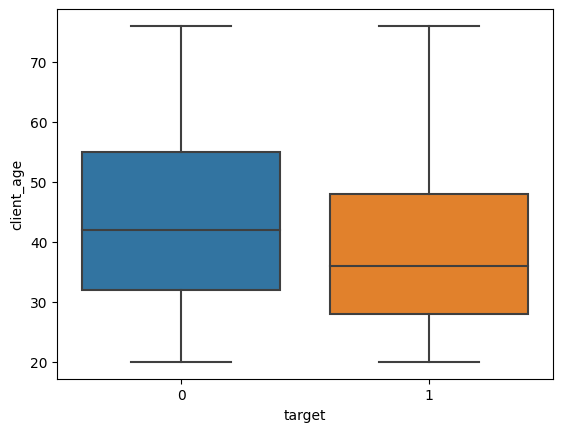

In [91]:
sns.boxplot(data=merged_train_static_cd_0_base_df, y="client_age", x="target")

<Axes: xlabel='client_age', ylabel='Proportion'>

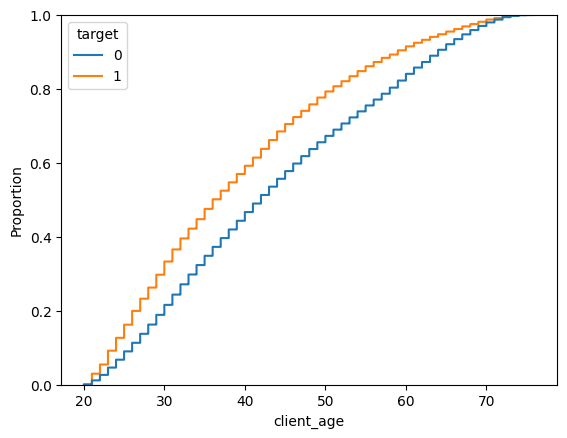

In [92]:
sns.ecdfplot(data=merged_train_static_cd_0_base_df, x="client_age", hue="target")

## target=1 has lower value of client_age

## 4. contractssum_5085716L

In [56]:
get_column_description(feature_df, "contractssum_5085716L")

'Total sum of values of contracts retrieved from external credit bureau.'

In [57]:
merged_train_static_cd_0_base_df.contractssum_5085716L.isnull().value_counts()

contractssum_5085716L
True     1369330
False     157329
Name: count, dtype: int64

<Axes: xlabel='target', ylabel='contractssum_5085716L'>

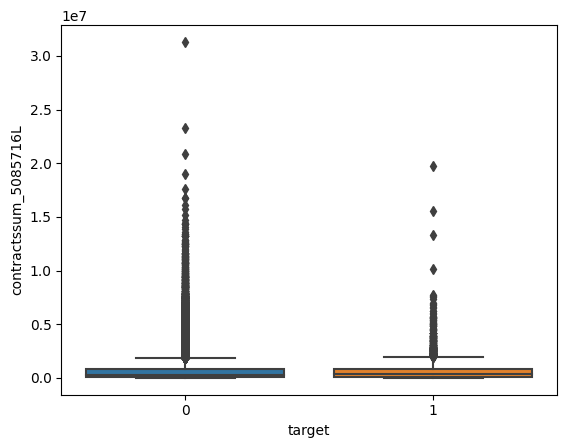

In [58]:
sns.boxplot(data=merged_train_static_cd_0_base_df, y="contractssum_5085716L", x="target")

<Axes: xlabel='contractssum_5085716L', ylabel='Proportion'>

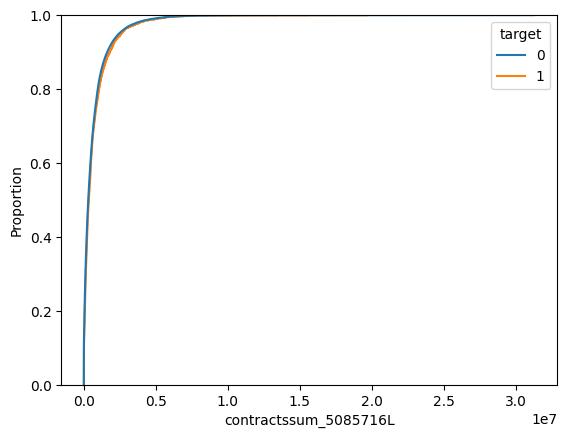

In [59]:
sns.ecdfplot(data=merged_train_static_cd_0_base_df, x="contractssum_5085716L", hue="target")

In [64]:
# sc_plot = plot_scatterplot(merged_train_static_cd_0_base_df, "contractssum_5085716L", "client_age", show_x_y_line=False)
# sc_plot.show()

## It is possible that this is sum of all the other contracts/ loans that the case_id has

## 5. dateofbirth_337D

In [65]:
get_column_description(feature_df, "dateofbirth_337D")

"Client's date of birth."

In [66]:
merged_train_static_cd_0_base_df.dateofbirth_337D.isnull().value_counts()

dateofbirth_337D
False    1385691
True      140968
Name: count, dtype: int64

In [81]:
merged_train_static_cd_0_base_df.dateofbirth_337D.describe()

count                          1385691
mean     1975-03-31 03:29:19.475380960
min                1900-01-01 00:00:00
25%                1963-12-01 00:00:00
50%                1977-01-01 00:00:00
75%                1986-11-01 00:00:00
max                2020-01-01 00:00:00
Name: dateofbirth_337D, dtype: object

## 1900-01-01 to 2020-01-01 Does not appear to be correct. IGNORE

## 6. dateofbirth_342D

In [85]:
get_column_description(feature_df, "dateofbirth_342D")

"Client's date of birth."

In [86]:
merged_train_static_cd_0_base_df.dateofbirth_342D.isnull().value_counts()

dateofbirth_342D
True     1490159
False      36500
Name: count, dtype: int64

In [87]:
merged_train_static_cd_0_base_df.dateofbirth_342D.describe()

count                            36500
mean     1977-09-16 00:28:47.999999968
min                1915-01-01 00:00:00
25%                1967-12-01 00:00:00
50%                1979-08-01 00:00:00
75%                1988-08-01 00:00:00
max                2015-09-01 00:00:00
Name: dateofbirth_342D, dtype: object

## 1915-01-01 to 2015-09-01. Does not ppear to be correct. IGNORE

## 7. days30_165L

In [93]:
get_column_description(feature_df, "days30_165L")

'Number of credit bureau queries for the last 30 days.'

In [94]:
merged_train_static_cd_0_base_df.days30_165L.isnull().value_counts(normalize=True)

days30_165L
False    0.907662
True     0.092338
Name: proportion, dtype: float64

<Axes: xlabel='target', ylabel='days30_165L'>

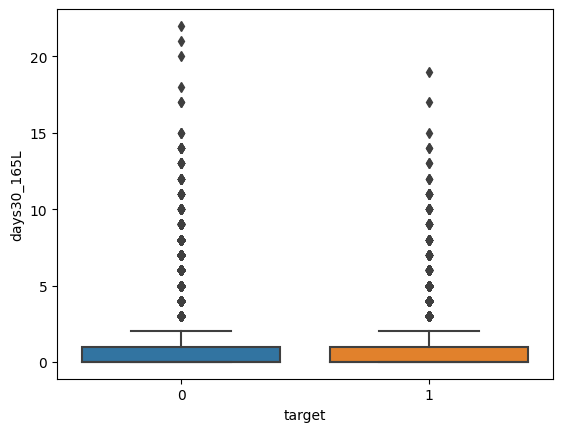

In [95]:
sns.boxplot(data=merged_train_static_cd_0_base_df, y="days30_165L", x="target")

<Axes: xlabel='days30_165L', ylabel='Proportion'>

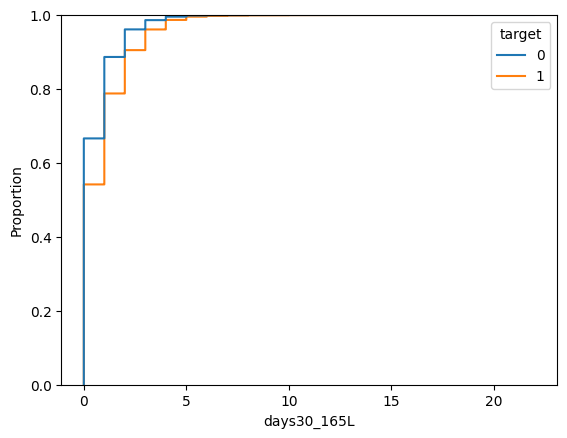

In [96]:
sns.ecdfplot(data=merged_train_static_cd_0_base_df, x="days30_165L", hue="target")

## 8. days90_310L

In [97]:
get_column_description(feature_df, "days90_310L")

'Number of credit bureau queries for the last 90 days.'

In [98]:
merged_train_static_cd_0_base_df.days90_310L.isnull().value_counts(normalize=True)

days90_310L
False    0.907662
True     0.092338
Name: proportion, dtype: float64

<Axes: xlabel='target', ylabel='days90_310L'>

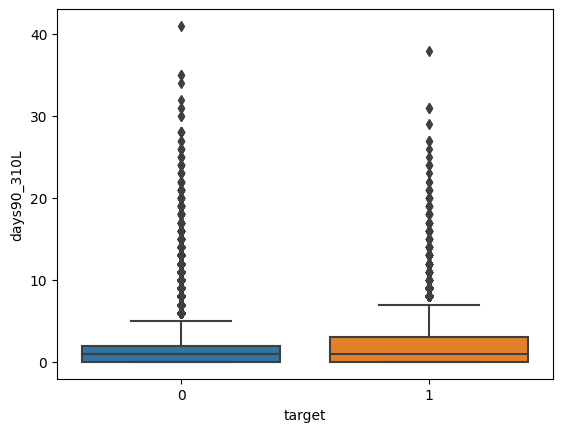

In [99]:
sns.boxplot(data=merged_train_static_cd_0_base_df, y="days90_310L", x="target")

<Axes: xlabel='days90_310L', ylabel='Proportion'>

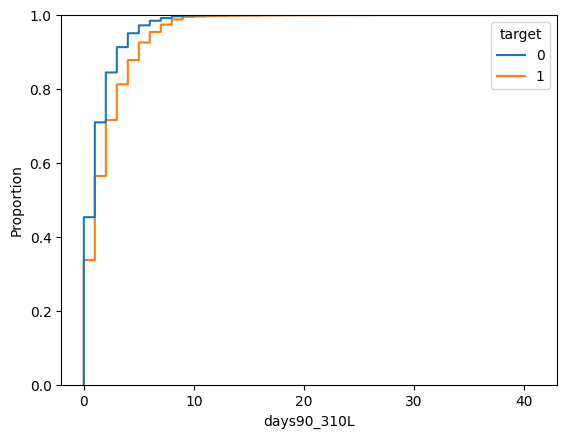

In [100]:
sns.ecdfplot(data=merged_train_static_cd_0_base_df, x="days90_310L", hue="target")

## 9. days120_123L

In [101]:
get_column_description(feature_df, "days120_123L")

'Number of credit bureau queries for the last 120 days.'

In [102]:
merged_train_static_cd_0_base_df.days120_123L.isnull().value_counts(normalize=True)

days120_123L
False    0.907662
True     0.092338
Name: proportion, dtype: float64

<Axes: xlabel='target', ylabel='days120_123L'>

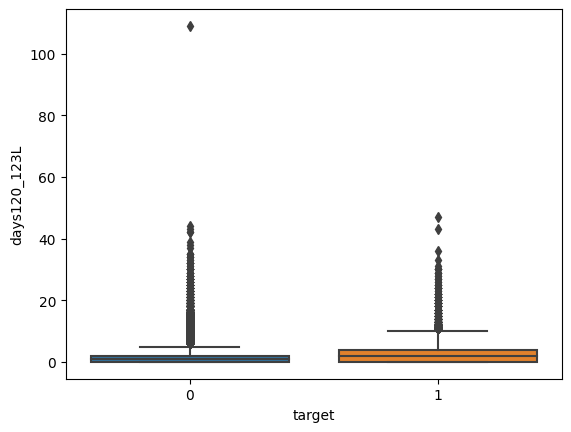

In [103]:
sns.boxplot(data=merged_train_static_cd_0_base_df, y="days120_123L", x="target")

<Axes: xlabel='days120_123L', ylabel='Proportion'>

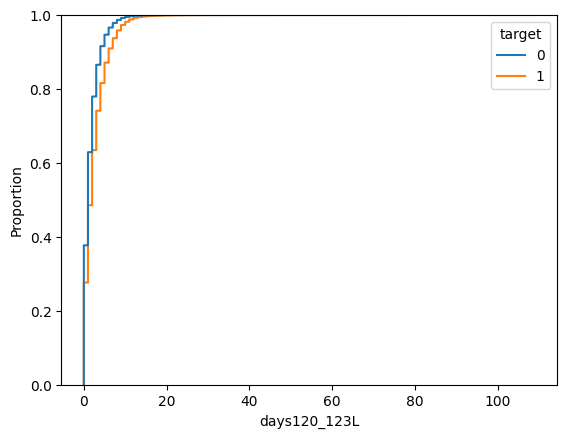

In [104]:
sns.ecdfplot(data=merged_train_static_cd_0_base_df, x="days120_123L", hue="target")

## target=1 has higher number of credit queries in past 120 days

## 10. days180_256L

In [105]:
get_column_description(feature_df, "days180_256L")

'Number of credit bureau queries for last 180 days.'

In [106]:
merged_train_static_cd_0_base_df.days180_256L.isnull().value_counts(normalize=True)

days180_256L
False    0.907662
True     0.092338
Name: proportion, dtype: float64

<Axes: xlabel='target', ylabel='days180_256L'>

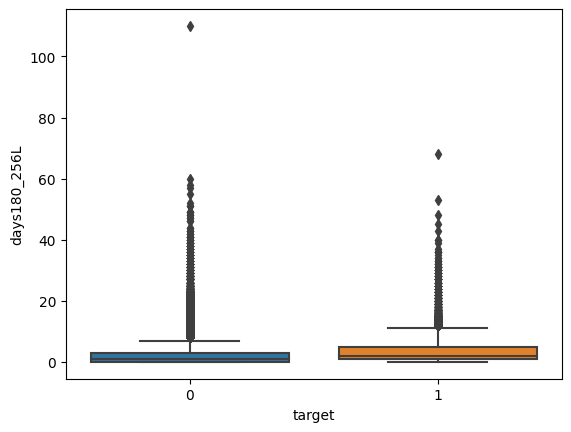

In [107]:
sns.boxplot(data=merged_train_static_cd_0_base_df, y="days180_256L", x="target")

<Axes: xlabel='days180_256L', ylabel='Proportion'>

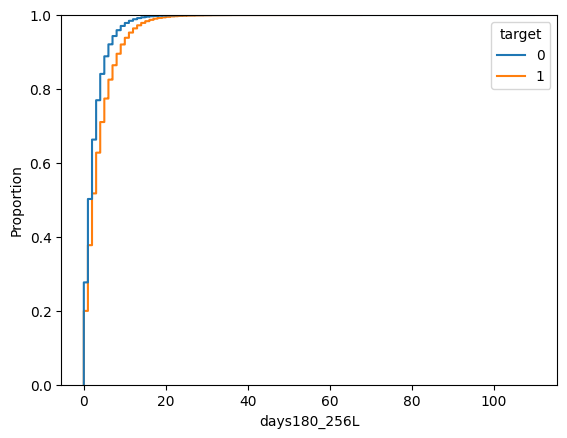

In [108]:
sns.ecdfplot(data=merged_train_static_cd_0_base_df, x="days180_256L", hue="target")

## target=1 has higher number of credit queries in past 180 days

## 11. days360_512L

In [113]:
get_column_description(feature_df, "days360_512L")

'Number of Credit Bureau queries for last 360 days.'

In [114]:
merged_train_static_cd_0_base_df.days360_512L.isnull().value_counts(normalize=True)

days360_512L
False    0.907662
True     0.092338
Name: proportion, dtype: float64

<Axes: xlabel='target', ylabel='days360_512L'>

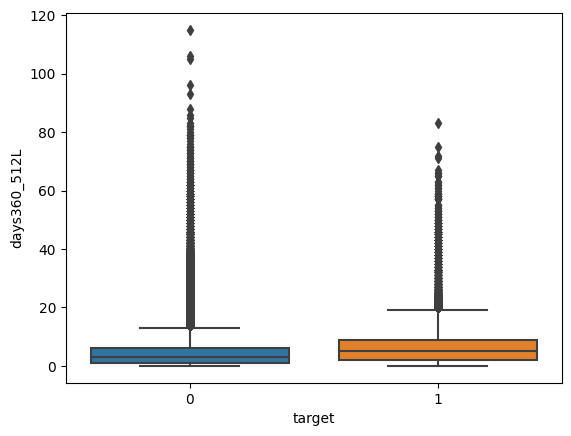

In [115]:
sns.boxplot(data=merged_train_static_cd_0_base_df, y="days360_512L", x="target")

<Axes: xlabel='days360_512L', ylabel='Proportion'>

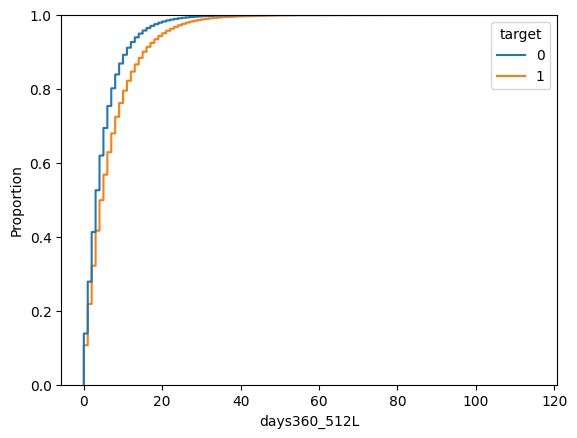

In [112]:
sns.ecdfplot(data=merged_train_static_cd_0_base_df, x="days360_512L", hue="target")

## target=1 has higher number of credit queries in past 360 days

## 12. description_5085714M

In [117]:
get_column_description(feature_df, "description_5085714M")

'Categorization of clients by credit bureau.'

In [118]:
merged_train_static_cd_0_base_df.description_5085714M.isnull().value_counts(normalize=True)

description_5085714M
False    0.982849
True     0.017151
Name: proportion, dtype: float64

In [119]:
merged_train_static_cd_0_base_df.description_5085714M.value_counts()

description_5085714M
a55475b1    1316125
2fc785b2     184351
Name: count, dtype: int64

In [122]:
percentage_default_description_5085714M_df = get_percent_of_column(merged_train_static_cd_0_base_df, "description_5085714M", "target")

/var/folders/qr/cmfkzy495k7b3bn80b7ygs080000gn/T/ipykernel_17646/3378707336.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  bar_plot.show()


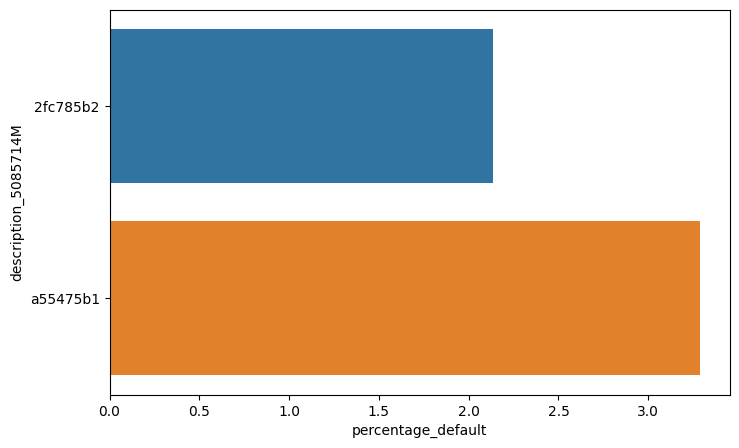

In [127]:
bar_plot = plot_barplot(percentage_default_description_5085714M_df, "percentage_default", "description_5085714M")
bar_plot.show()

## It appears that there is difference in default percentage for differernt description_5085714M

## 13. education_1103M

In [128]:
get_column_description(feature_df, "education_1103M")

'Level of education of the client provided by external source.'

In [129]:
merged_train_static_cd_0_base_df.education_1103M.isnull().value_counts(normalize=True)

education_1103M
False    0.982849
True     0.017151
Name: proportion, dtype: float64

In [130]:
merged_train_static_cd_0_base_df.education_1103M.value_counts()

education_1103M
a55475b1    859962
6b2ae0fa    452449
717ddd49    135342
39a0853f     47140
c8e1a1d0      5583
Name: count, dtype: int64

In [131]:
percentage_default_education_1103M_df = get_percent_of_column(merged_train_static_cd_0_base_df, "education_1103M", "target")

/var/folders/qr/cmfkzy495k7b3bn80b7ygs080000gn/T/ipykernel_17646/420501965.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  bar_plot.show()


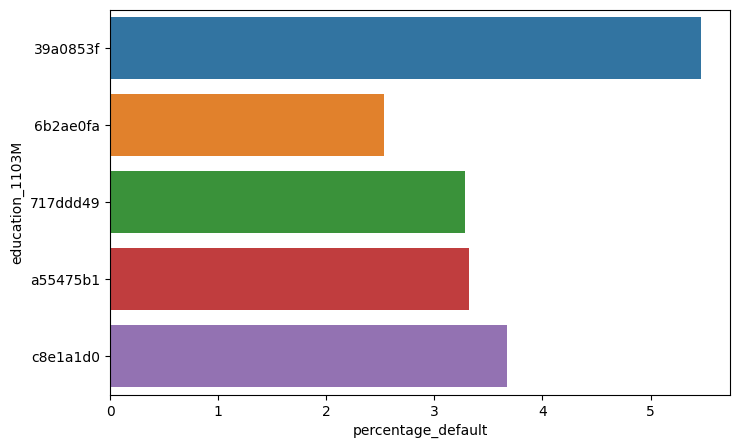

In [132]:
bar_plot = plot_barplot(percentage_default_education_1103M_df, "percentage_default", "education_1103M")
bar_plot.show()

## 14. education_88M

In [134]:
get_column_description(feature_df, "education_88M")

'Education level of the client.'

In [135]:
merged_train_static_cd_0_base_df.education_88M.isnull().value_counts(normalize=True)

education_88M
False    0.982849
True     0.017151
Name: proportion, dtype: float64

In [136]:
merged_train_static_cd_0_base_df.education_88M.value_counts()

education_88M
a55475b1    1484960
6b2ae0fa      11673
717ddd49       3280
a34a13c8        437
c8e1a1d0        126
Name: count, dtype: int64

In [137]:
percentage_default_education_88M_df = get_percent_of_column(merged_train_static_cd_0_base_df, "education_88M", "target")

/var/folders/qr/cmfkzy495k7b3bn80b7ygs080000gn/T/ipykernel_17646/3869461033.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  bar_plot.show()


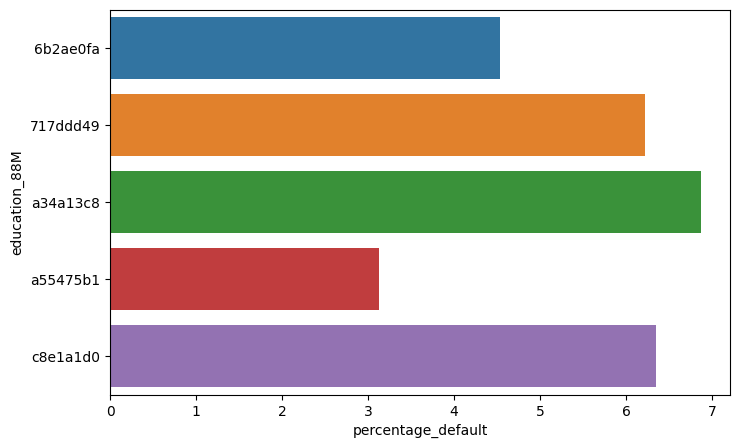

In [138]:
bar_plot = plot_barplot(percentage_default_education_88M_df, "percentage_default", "education_88M")
bar_plot.show()

## 15. firstquarter_103L, secondquarter_766L, thirdquarter_1082L, fourthquarter_440L

In [143]:
get_column_description(feature_df, "firstquarter_103L")

'Number of results obtained from credit bureau in the first quarter.'

In [140]:
get_column_description(feature_df, "secondquarter_766L")

'Number of results in second quarter.'

In [141]:
get_column_description(feature_df, "thirdquarter_1082L")

'Number of results in third quarter.'

In [142]:
get_column_description(feature_df, "fourthquarter_440L")

'Number of results in fourth quarter.'

## 16. for3years_128L

In [144]:
get_column_description(feature_df, "for3years_128L")

'Number of rejected applications in the past 3 years.'

In [145]:
merged_train_static_cd_0_base_df.for3years_128L.isnull().value_counts(normalize=True)

for3years_128L
True     0.976082
False    0.023918
Name: proportion, dtype: float64

In [152]:
merged_train_static_cd_0_base_df.for3years_128L.value_counts().head(5)

for3years_128L
0.0    36511
1.0        3
Name: count, dtype: int64

## 17. for3years_504L

In [146]:
get_column_description(feature_df, "for3years_504L")

"Client's credit history data over the last three years."

In [147]:
merged_train_static_cd_0_base_df.for3years_504L.isnull().value_counts(normalize=True)

for3years_504L
True     0.976082
False    0.023918
Name: proportion, dtype: float64

In [151]:
merged_train_static_cd_0_base_df.for3years_504L.value_counts().head(5)

for3years_504L
0.0    10443
1.0     5484
2.0     3701
3.0     2459
4.0     2111
Name: count, dtype: int64

## 18. for3years_584L

In [153]:
get_column_description(feature_df, "for3years_584L")

'Number of cancellations in the last 3 years.'

In [154]:
merged_train_static_cd_0_base_df.for3years_584L.isnull().value_counts(normalize=True)

for3years_584L
True     0.976082
False    0.023918
Name: proportion, dtype: float64

In [155]:
merged_train_static_cd_0_base_df.for3years_584L.value_counts().head(5)

for3years_584L
0.0    36245
1.0      257
2.0       12
Name: count, dtype: int64

## 19. formonth_118L

In [156]:
get_column_description(feature_df, "formonth_118L")

'Number of rejections in a month.'

In [157]:
merged_train_static_cd_0_base_df.formonth_118L.isnull().value_counts(normalize=True)

formonth_118L
True     0.976082
False    0.023918
Name: proportion, dtype: float64

In [158]:
merged_train_static_cd_0_base_df.formonth_118L.value_counts().head(5)

formonth_118L
0.0    36514
Name: count, dtype: int64

## 20. formonth_206L

In [159]:
get_column_description(feature_df, "formonth_206L")

'Number of cancelations in the previous month.'

In [160]:
merged_train_static_cd_0_base_df.formonth_206L.isnull().value_counts(normalize=True)

formonth_206L
True     0.976082
False    0.023918
Name: proportion, dtype: float64

In [161]:
merged_train_static_cd_0_base_df.formonth_206L.value_counts().head(5)

formonth_206L
0.0    36501
1.0       13
Name: count, dtype: int64

## 21. formonth_535L

In [166]:
get_column_description(feature_df, "formonth_535L")

'Credit history for the last month.'

In [167]:
merged_train_static_cd_0_base_df.formonth_535L.isnull().value_counts(normalize=True)

formonth_535L
True     0.976082
False    0.023918
Name: proportion, dtype: float64

In [168]:
merged_train_static_cd_0_base_df.formonth_535L.value_counts().head(5)

formonth_535L
0.0    29492
1.0     5616
2.0     1240
3.0      135
4.0       20
Name: count, dtype: int64

## 22. forquarter_1017L

In [169]:
get_column_description(feature_df, "forquarter_1017L")

'Number of cancellations recorded in the credit bureau in the last quarter.'

In [170]:
merged_train_static_cd_0_base_df.forquarter_1017L.isnull().value_counts(normalize=True)

forquarter_1017L
True     0.976082
False    0.023918
Name: proportion, dtype: float64

## 23. forquarter_462L

In [171]:
get_column_description(feature_df, "forquarter_462L")

'Number of credit applications that were rejected in the last quarter.'

In [172]:
merged_train_static_cd_0_base_df.forquarter_462L.isnull().value_counts(normalize=True)

forquarter_462L
True     0.976082
False    0.023918
Name: proportion, dtype: float64

In [173]:
merged_train_static_cd_0_base_df.forquarter_462L.value_counts().head(5)

forquarter_462L
0.0    36514
Name: count, dtype: int64

## 24. forquarter_634L

In [174]:
get_column_description(feature_df, "forquarter_634L")

'Credit history for the last quarter.'

## 25. fortoday_1092L

In [176]:
get_column_description(feature_df, "forweek_1077L")

'Number of cancelations in the last week.'

## 26. maritalst_385M

In [177]:
get_column_description(feature_df, "maritalst_385M")

'Marital status of the client.'

In [178]:
merged_train_static_cd_0_base_df.maritalst_385M.isnull().value_counts(normalize=True)

maritalst_385M
False    0.982849
True     0.017151
Name: proportion, dtype: float64

In [179]:
merged_train_static_cd_0_base_df.maritalst_385M.value_counts(normalize=True)

maritalst_385M
a55475b1    0.440921
3439d993    0.366774
a7fcb6e5    0.133991
b6cabe76    0.037255
38c061ee    0.017895
ecd83604    0.003164
Name: proportion, dtype: float64

In [180]:
percentage_default_maritalst_385M_df = get_percent_of_column(merged_train_static_cd_0_base_df, "maritalst_385M", "target")

/var/folders/qr/cmfkzy495k7b3bn80b7ygs080000gn/T/ipykernel_17646/4036844696.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  bar_plot.show()


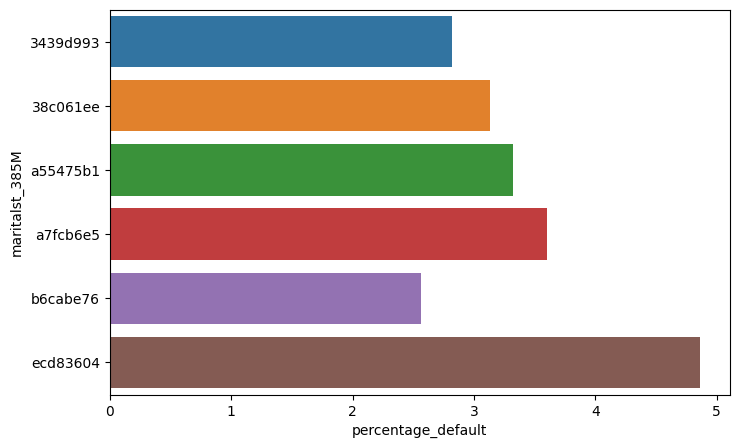

In [181]:
bar_plot = plot_barplot(percentage_default_maritalst_385M_df, "percentage_default", "maritalst_385M")
bar_plot.show()

## 27. maritalst_893M

In [183]:
get_column_description(feature_df, "maritalst_893M")

'Marital status of the client'

In [184]:
merged_train_static_cd_0_base_df.maritalst_893M.isnull().value_counts(normalize=True)

maritalst_893M
False    0.982849
True     0.017151
Name: proportion, dtype: float64

## 28. numberofqueries_373L

In [185]:
get_column_description(feature_df, "numberofqueries_373L")

'Number of queries to credit bureau.'

In [186]:
merged_train_static_cd_0_base_df.numberofqueries_373L.isnull().value_counts(normalize=True)

numberofqueries_373L
False    0.907662
True     0.092338
Name: proportion, dtype: float64

<Axes: xlabel='target', ylabel='numberofqueries_373L'>

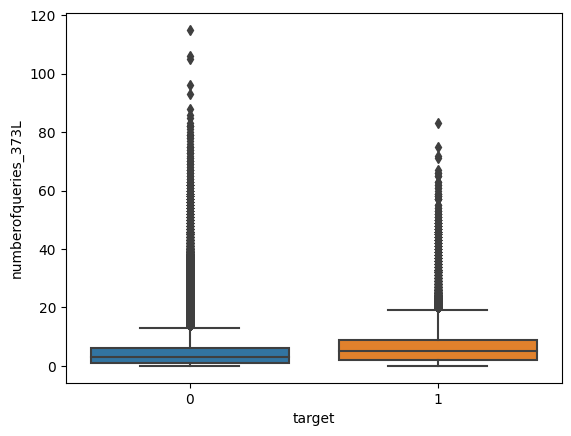

In [187]:
sns.boxplot(data=merged_train_static_cd_0_base_df, y="numberofqueries_373L", x="target")

<Axes: xlabel='numberofqueries_373L', ylabel='Proportion'>

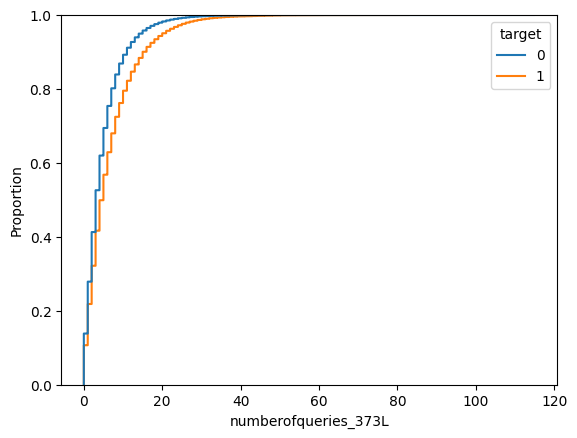

In [188]:
sns.ecdfplot(data=merged_train_static_cd_0_base_df, x="numberofqueries_373L", hue="target")

## 29. pmtaverage_3A

In [189]:
get_column_description(feature_df, "pmtaverage_3A")

'Average of tax deductions.'

In [190]:
get_column_description(feature_df, "pmtaverage_4527227A")

'Average of tax deductions.'

In [191]:
get_column_description(feature_df, "pmtaverage_4955615A")

'Average of tax deductions.'

In [197]:
merged_train_static_cd_0_base_df.pmtaverage_3A.isnull().value_counts(normalize=True)

pmtaverage_3A
True     0.905946
False    0.094054
Name: proportion, dtype: float64

<Axes: xlabel='target', ylabel='pmtaverage_3A'>

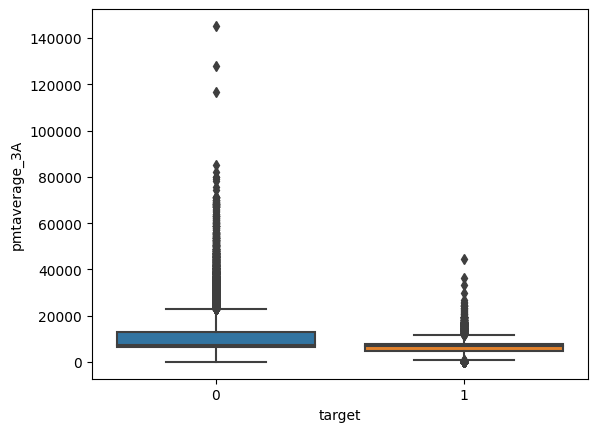

In [198]:
sns.boxplot(data=merged_train_static_cd_0_base_df, y="pmtaverage_3A", x="target")

<Axes: xlabel='pmtaverage_3A', ylabel='Proportion'>

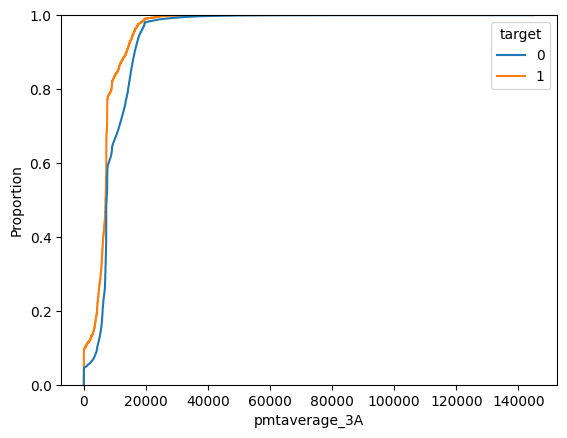

In [199]:
sns.ecdfplot(data=merged_train_static_cd_0_base_df, x="pmtaverage_3A", hue="target")

## 30. pmtscount_423L

In [214]:
get_column_description(feature_df, "pmtscount_423L")

'Number of tax deduction payments.'

In [215]:
merged_train_static_cd_0_base_df.pmtscount_423L.isnull().value_counts(normalize=True)

pmtscount_423L
True     0.624908
False    0.375092
Name: proportion, dtype: float64

<Axes: xlabel='target', ylabel='pmtscount_423L'>

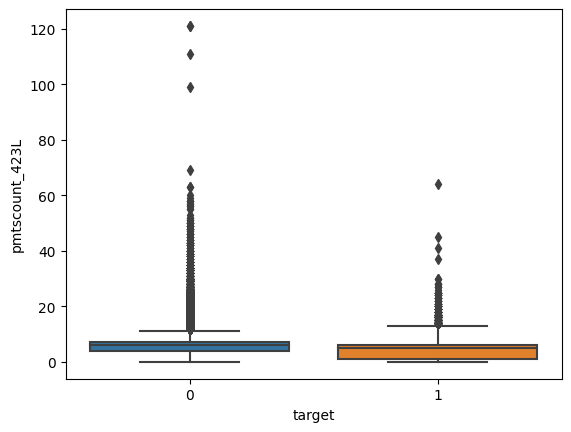

In [217]:
sns.boxplot(data=merged_train_static_cd_0_base_df, y="pmtscount_423L", x="target")

<Axes: xlabel='pmtscount_423L', ylabel='Proportion'>

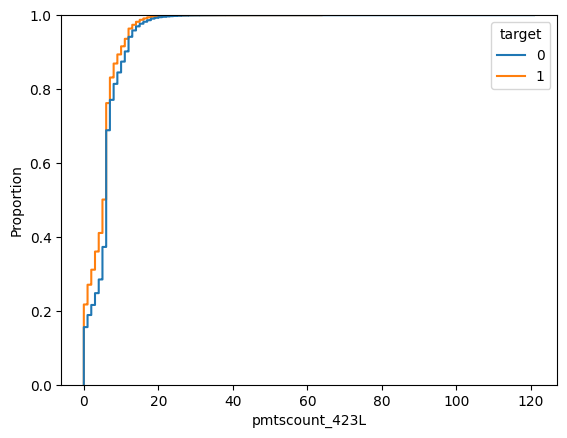

In [218]:
sns.ecdfplot(data=merged_train_static_cd_0_base_df, x="pmtscount_423L", hue="target")

## 31. pmtssum_45A

In [219]:
get_column_description(feature_df, "pmtssum_45A")

'Sum of tax deductions for the client.'

In [220]:
merged_train_static_cd_0_base_df.pmtssum_45A.isnull().value_counts(normalize=True)

pmtssum_45A
True     0.624908
False    0.375092
Name: proportion, dtype: float64

<Axes: xlabel='target', ylabel='pmtssum_45A'>

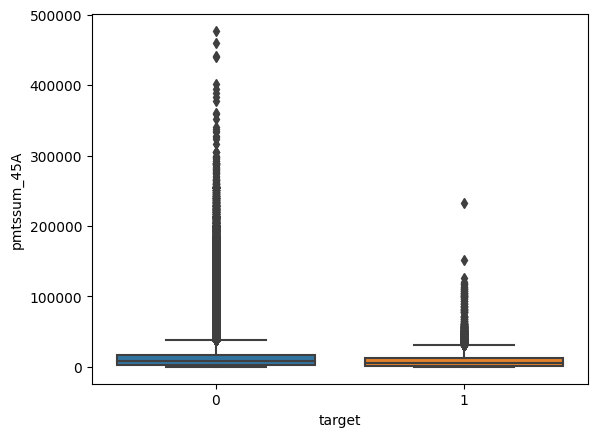

In [221]:
sns.boxplot(data=merged_train_static_cd_0_base_df, y="pmtssum_45A", x="target")

<Axes: xlabel='pmtssum_45A', ylabel='Proportion'>

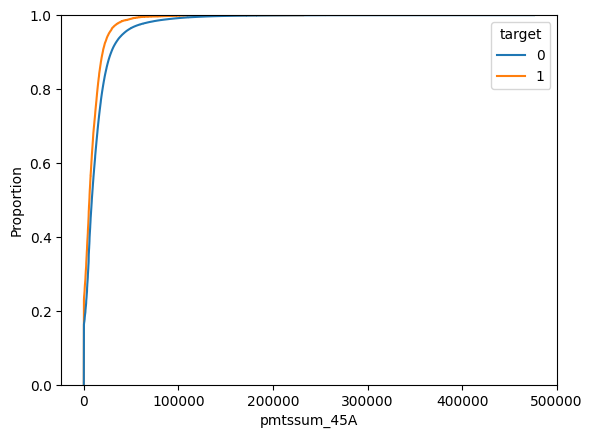

In [222]:
sns.ecdfplot(data=merged_train_static_cd_0_base_df, x="pmtssum_45A", hue="target")

## 32. requesttype_4525192L

In [223]:
get_column_description(feature_df, "requesttype_4525192L")

'Tax authority request type.'

In [224]:
merged_train_static_cd_0_base_df.requesttype_4525192L.isnull().value_counts(normalize=True)

requesttype_4525192L
True     0.558995
False    0.441005
Name: proportion, dtype: float64

In [225]:
merged_train_static_cd_0_base_df.requesttype_4525192L.value_counts(normalize=True)

requesttype_4525192L
DEDUCTION_6    0.817491
PENSION_6      0.173850
SOCIAL_6       0.008659
Name: proportion, dtype: float64

In [226]:
percentage_default_requesttype_4525192L_df = get_percent_of_column(merged_train_static_cd_0_base_df, "requesttype_4525192L", "target")

/var/folders/qr/cmfkzy495k7b3bn80b7ygs080000gn/T/ipykernel_17646/2166689233.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  bar_plot.show()


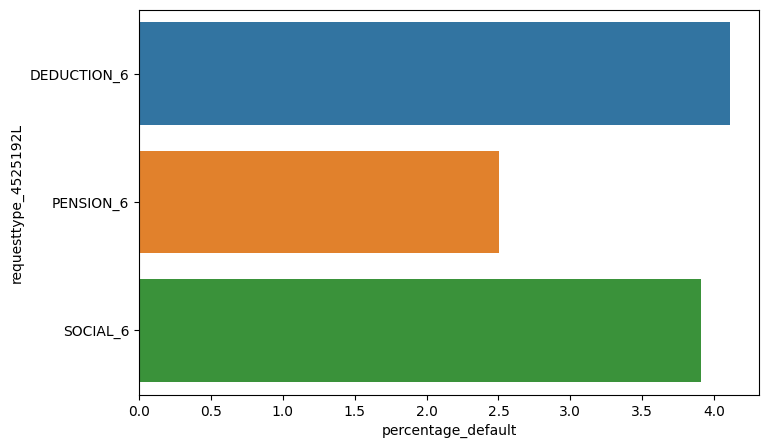

In [227]:
bar_plot = plot_barplot(percentage_default_requesttype_4525192L_df, "percentage_default", "requesttype_4525192L")
bar_plot.show()

In [228]:
percentage_default_requesttype_4525192L_df

,requesttype_4525192L,target,total_rows,percentage_default
0,DEDUCTION_6,22605,550387,4.107110
1,PENSION_6,2933,117047,2.505831
2,SOCIAL_6,228,5830,3.910806


## 33. riskassesment_302T

In [231]:
get_column_description(feature_df, "riskassesment_940T")

"Estimate of client's creditworthiness."